In [86]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import yaml
import matplotlib.pyplot as plt 
import datetime

import warnings
warnings.filterwarnings('ignore')

# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format
theme_set(theme_linedraw()) # default theme

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import yaml
from jinja2 import Template
cf.themes.THEMES['custom'] = yaml.load(open('cufflinks_template.yaml', 'r'))

# Manipulation 
from siuba import *

# Loading data

In [87]:
from src import utils
from datetime import datetime
conn = utils.connect_athena(path='../configs/athena.yaml')

In [88]:
df = pd.read_sql_query("""
select 
    *,
    date_parse(concat('2020', ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e')
from spd_sdv_waze_corona.prod_daily_daily_index
where country_iso_code = 'MX'
""", conn)

# Exploratory analysis

In [89]:
print(df.shape)
df.columns

(4080, 20)


Index(['last_updated_utc', 'region_slug', 'region_name', 'country_name',
       'country_iso_code', 'country_idb_code', 'region_type', 'population',
       'timezone', 'year', 'month', 'day', 'dow', 'observed', 'expected_2020',
       'ratio_20', 'tcp', 'dashboard', 'region_shapefile_wkt', '_col19'],
      dtype='object')

In [90]:
df['year'] = 2020
df['year'][df.month <= 2] = 2021
df['date'] = pd.to_datetime(df[['year','month','day']]
                            .astype(str).apply(' '.join, 1), format='%Y %m %d')
df['datetime'] = df['date'].astype(str).apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))

In [91]:
# Equivale a athena spd_sdv_waze_corona.prod_daily_daily_index
#df = pd.read_csv('~/shared/spd-sdv-omitnik-waze/corona/prod/private/daily/write_index/write_index_daily.csv', sep = "|")
#df = df[df.month != 'TRUE']
#print(df.shape)

In [92]:
print(min(df.date))
print(max(df.date))
df.describe()

2020-03-09 00:00:00
2021-02-11 00:00:00


,year,month,day,dow,observed,expected_2020,ratio_20,tcp
count,4080.000000,4080.000000,4080.000000,4080.000000,4.080000e+03,4.080000e+03,4080.000000,4080.000000
mean,2020.123529,6.835294,15.770588,3.982353,5.052680e+07,5.927803e+07,0.822399,-17.760129
std,0.329084,3.369291,8.824864,1.998696,1.358989e+08,1.207969e+08,0.669114,66.911447
min,2020.000000,1.000000,1.000000,1.000000,1.299180e+05,6.317860e+05,0.079478,-92.052232
25%,2020.000000,4.000000,8.000000,2.000000,2.504145e+06,4.221934e+06,0.384310,-61.569001
50%,2020.000000,7.000000,16.000000,4.000000,5.577110e+06,1.123330e+07,0.675560,-32.444049
75%,2020.000000,10.000000,23.000000,6.000000,1.789519e+07,3.278052e+07,0.993613,-0.638733
max,2021.000000,12.000000,31.000000,7.000000,1.252923e+09,5.187512e+08,7.468349,646.834889


In [93]:
print(len(df['region_slug'].unique()))
df['country_name'].unique()

12


array(['Mexico'], dtype=object)

Days observed per region_slug

In [94]:
df \
  .siu_group_by('region_slug', "country_name") \
  .siu_summarize(nc = _.tcp.count(),
                 tcp = _.tcp.mean(),
                 tcp_min = _.tcp.min(),
                 tcp_max = _.tcp.max(),
                 dat_min = _.date.min(),
                 dat_max = _.date.max()
                 ) \
  .siu_ungroup()

,region_slug,country_name,nc,tcp,tcp_min,tcp_max,dat_min,dat_max
0,aguascalientes,Mexico,340,-19.245102,-89.772846,295.093715,2020-03-09,2021-02-11
1,country_mexico,Mexico,340,4.190276,-83.873186,236.146628,2020-03-09,2021-02-11
2,guadalajara,Mexico,340,-34.081126,-88.839614,101.185662,2020-03-09,2021-02-11
3,leon,Mexico,340,-15.132970,-90.705502,171.461936,2020-03-09,2021-02-11
4,merida,Mexico,340,-44.337478,-85.996939,69.881371,2020-03-09,2021-02-11
5,mexicocity,Mexico,340,-40.514749,-92.052232,80.020119,2020-03-09,2021-02-11
6,monterrey,Mexico,340,-43.234677,-89.642462,234.132600,2020-03-09,2021-02-11
7,pueble,Mexico,340,-29.942371,-81.048294,90.490344,2020-03-09,2021-02-11
8,queretaro,Mexico,340,-44.612150,-89.328917,105.990360,2020-03-09,2021-02-11
9,sanluispotosi,Mexico,340,-7.896579,-91.638874,457.361712,2020-03-09,2021-02-11


TCI observations per date 

In [95]:
tab = df \
      .siu_group_by('region_slug', "country_name", "date") \
      .siu_summarize(nc = _.tcp.count(),
                     tcp = _.tcp.mean(),
                     tcp_min = _.tcp.min(),
                     tcp_max = _.tcp.max()
                     ) \
      .siu_ungroup()
tab.head()

,region_slug,country_name,date,nc,tcp,tcp_min,tcp_max
0,aguascalientes,Mexico,2020-03-09,1,-42.103947,-42.103947,-42.103947
1,aguascalientes,Mexico,2020-03-10,1,3.740975,3.740975,3.740975
2,aguascalientes,Mexico,2020-03-11,1,8.477060,8.477060,8.477060
3,aguascalientes,Mexico,2020-03-12,1,13.016856,13.016856,13.016856
4,aguascalientes,Mexico,2020-03-13,1,-6.457111,-6.457111,-6.457111


In [96]:
print(tab.shape)
tab.siu_filter(_.nc > 1).shape

(4080, 7)


(0, 7)

In [97]:
#tab.siu_filter(_.nc > 1).head()

# Feature creation

### TCI time serie per region

In [98]:
df_sel = (df
 >> select('date', 'dow', 'region_slug', 'tcp', 'observed', 'expected_2020', 'ratio_20', 'population')
 >> arrange(_.region_slug, _.date)
 >> mutate(observed_log = _.observed)
 >> group_by('region_slug')
 >> mutate(observed_1day = _.observed.shift(1),
           observed_7day = _.observed.shift(7))
 >> ungroup()
 >> group_by('region_slug', 'dow')    
 >> mutate(observed_1dow = _.observed.shift(1))          
 >> ungroup()          
 >> mutate(diff_1day = _.observed - _.observed_1day,
           diff_7day = _.observed - _.observed_7day)         
)

In [99]:
df_sel.head(8)

,date,dow,region_slug,tcp,observed,expected_2020,ratio_20,population,observed_log,observed_1day,observed_7day,observed_1dow,diff_1day,diff_7day
0,2020-03-09,1,aguascalientes,-42.103947,1263784,2182850.0,0.578961,911397,1263784,NaN,NaN,NaN,NaN,NaN
1,2020-03-10,2,aguascalientes,3.740975,2865805,2762462.0,1.037410,911397,2865805,1263784.0,NaN,NaN,1602021.0,NaN
2,2020-03-11,3,aguascalientes,8.477060,3073397,2833223.0,1.084771,911397,3073397,2865805.0,NaN,NaN,207592.0,NaN
3,2020-03-12,4,aguascalientes,13.016856,3009640,2663001.0,1.130169,911397,3009640,3073397.0,NaN,NaN,-63757.0,NaN
4,2020-03-13,5,aguascalientes,-6.457111,3196426,3417070.0,0.935429,911397,3196426,3009640.0,NaN,NaN,186786.0,NaN
5,2020-03-14,6,aguascalientes,14.228133,3623811,3172433.0,1.142281,911397,3623811,3196426.0,NaN,NaN,427385.0,NaN
6,2020-03-15,7,aguascalientes,-5.568909,1381338,1462800.0,0.944311,911397,1381338,3623811.0,NaN,NaN,-2242473.0,NaN
7,2020-03-16,1,aguascalientes,-56.431179,951042,2182850.0,0.435688,911397,951042,1381338.0,1263784.0,1263784.0,-430296.0,-312742.0


## Plots 

In [100]:
df_sel[['date', 'observed', 'region_slug']] \
    .pivot(index='date', columns='region_slug', values='observed') \
    .iplot(
    #theme='custom',
    yTitle='TCI',
    title='TCI observed',
)

In [101]:
df_sel[['date', 'diff_1day', 'region_slug']] \
    .pivot(index='date', columns='region_slug', values='diff_1day') \
    .iplot(
    #theme='custom',
    yTitle='TCI',
    title='TCI difference one day',
)

In [102]:
df_sel[['date', 'diff_7day', 'region_slug']] \
    .pivot(index='date', columns='region_slug', values='diff_7day') \
    .iplot(
    #theme='custom',
    yTitle='TCI',
    title='TCI difference seven day',
)

In [103]:
#(ggplot(tt,
#        aes('date', 'diff', color='factor(region_slug)'))
# + geom_line()
# + geom_point()
# + theme(axis_text_x=element_text(angle=90)))

# Outliers detection

### Test-Train set

In [104]:
# train sample
y_train = df_sel.siu_filter(_.region_slug == 'aguascalientes') \
    .siu_arrange('date') \
    .siu_select('date', 'observed') \
    .set_index('date')
print(y_train.shape)
x_train = df_sel.siu_filter(_.region_slug == 'aguascalientes') \
    .siu_arrange('date') \
    .siu_select('date', 'observed_7day', 'observed_1day') \
    .set_index('date')
print(x_train.shape)

(340, 1)
(340, 2)


In [105]:
# Split train y test
# x_train, y_train, x_test, y_test = generate_data(n_train=200, n_test=100, n_features=2)


### Univariate with ADTK

In [106]:
from adtk.data import validate_series
from adtk.visualization import plot

In [107]:
s_train = validate_series(y_train)
print(s_train.head())
#plot(s_train)

            observed
date                
2020-03-09   1263784
2020-03-10   2865805
2020-03-11   3073397
2020-03-12   3009640
2020-03-13   3196426


[<AxesSubplot:>]

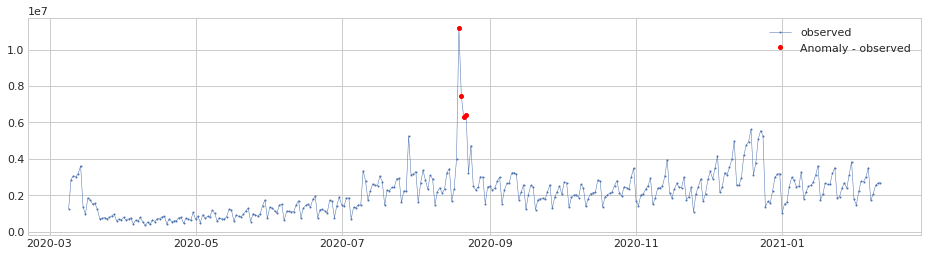

In [124]:
# SeasonalAD detects anomalous violations of seasonal pattern.
from adtk.detector import SeasonalAD
seasonal_ad = SeasonalAD()
anomalies = seasonal_ad.fit_detect(s_train)
plot(s_train, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

[<AxesSubplot:>]

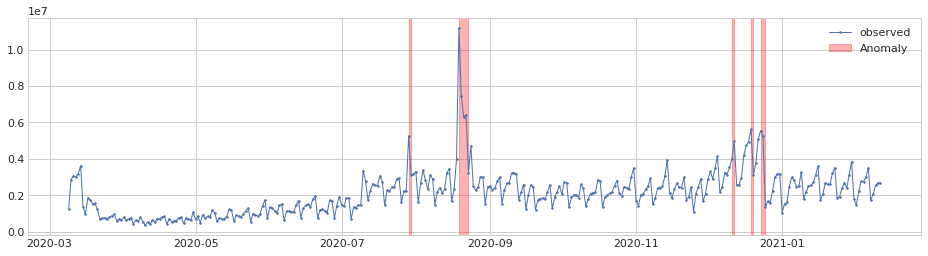

In [127]:
# OutlierDetector performs multivariate time-independent outlier 
# detection and identifies outliers as anomalies. 
# The multivariate outlier detection algorithm could be those in 
# scikit-learn or other packages following same API.
from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.025))
anomalies = outlier_detector.fit_detect(s_train)
plot(s_train, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')


In [133]:
# ClassicSeasonalDecomposition decomposes a series into trend part (optional), 
# seasonal part and residual part. The residual part may help identifying 
# anomalous deviation from seasonal pattern.

# QuantileAD compares each time series value with historical quantiles. 
# In the following example, we detect time points when temperature is 
# above 99% percentile or below 1% percentile.
from adtk.pipe import Pipeline
from adtk.detector import QuantileAD
from adtk.transformer import ClassicSeasonalDecomposition
quantile_ad = QuantileAD(high=0.95, low=0.01)
steps = [
    ("deseasonal", ClassicSeasonalDecomposition()),
    ("quantile_ad", QuantileAD(high=0.95, low=0.01))
]
pipeline = Pipeline(steps)

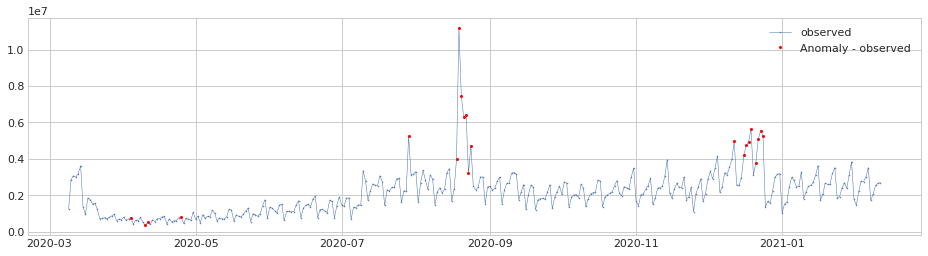

In [134]:
s = validate_series(s_train)
anomalies = pipeline.fit_detect(s)
plot(s, anomaly=anomalies, ts_markersize=1, anomaly_markersize=2, anomaly_tag="marker", anomaly_color='red');

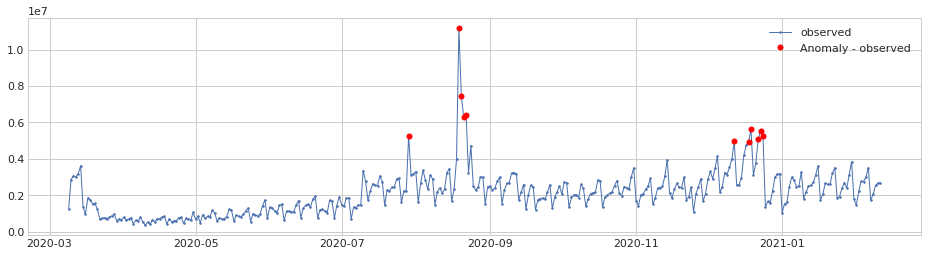

In [142]:
from adtk.detector import InterQuartileRangeAD
iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies = iqr_ad.fit_detect(s_train)
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

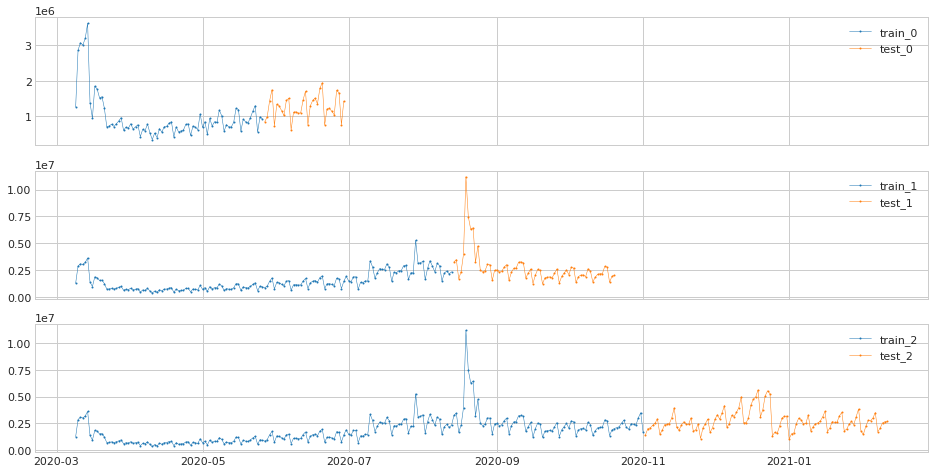

In [118]:
from adtk.data import split_train_test
splits = split_train_test(s, mode=2, n_splits=3)
df = pd.DataFrame(index=s.index)
for i, (train, test) in enumerate(splits):
    df["train_{}".format(i)] = train
    df["test_{}".format(i)] = test
plot(df, 
     curve_group=[("train_{}".format(i), "test_{}".format(i)) for i in range(3)],
     ts_color={**{"train_{}".format(i): "tab:blue" for i in range(3)}, **{"test_{}".format(i): "tab:orange" for i in range(3)}},
     figsize=(16, 8));

### Multivariate with PyOD

In [119]:
from pyod.models.abod import ABOD
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

In [120]:
x_train = x_train.dropna()
print(x_train.shape)
y_train = y_train[y_train.index.isin(x_train.index)]
print(y_train.shape)

(333, 2)
(333, 1)


In [121]:
clf = ABOD(method="fast") # initialize detector
clf.fit(x_train)

ABOD(contamination=0.1, method='fast', n_neighbors=5)

In [137]:
y_train_pred = clf.predict(x_train) # binary labels
y_train_scores = clf.decision_function(x_train) # raw outlier scores
y_train_proba = clf.predict_proba(x_train) # outlier probability

#evaluate_print("ABOD", y_train, y_train_scores) # performance evaluation
#ABOD Performance; ROC: 0.934; Precision at n: 0.902

In [138]:
#evaluate_print("ABOD", y_train, y_train_scores) # performance evaluation
visualize(y_train, y_train_pred)

TypeError: visualize() missing 5 required positional arguments: 'y_train', 'X_test', 'y_test', 'y_train_pred', and 'y_test_pred'

In [140]:
df
#y_train_pred

,train_0,test_0,train_1,test_1,train_2,test_2
date,,,,,,
2020-03-09,1263784.0,NaN,1263784.0,NaN,1263784.0,NaN
2020-03-10,2865805.0,NaN,2865805.0,NaN,2865805.0,NaN
2020-03-11,3073397.0,NaN,3073397.0,NaN,3073397.0,NaN
2020-03-12,3009640.0,NaN,3009640.0,NaN,3009640.0,NaN
2020-03-13,3196426.0,NaN,3196426.0,NaN,3196426.0,NaN
...,...,...,...,...,...,...
2021-02-07,NaN,NaN,NaN,NaN,NaN,1734005.0
2021-02-08,NaN,NaN,NaN,NaN,NaN,2048358.0
2021-02-09,NaN,NaN,NaN,NaN,NaN,2544541.0
